# ML-7. Прогнозирование биологического ответа (HW-3)

## Техническое задание:

Практика основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

- Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

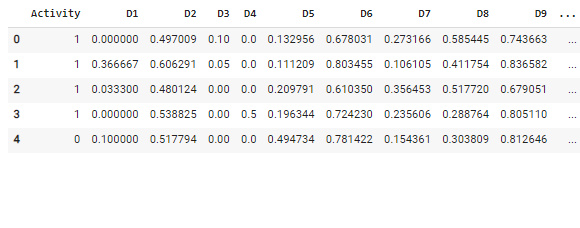

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: **логистическую регрессию и случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все **четыре метода** (*GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna*) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## Выполнение практического задания

импорт библиотек

In [27]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
import warnings
warnings.filterwarnings("ignore")

подгрузка данных

In [28]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

In [29]:
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

Проверяем на дубликаты:

In [30]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (3751, 1777)


Смотрим на сбалансированность классов:

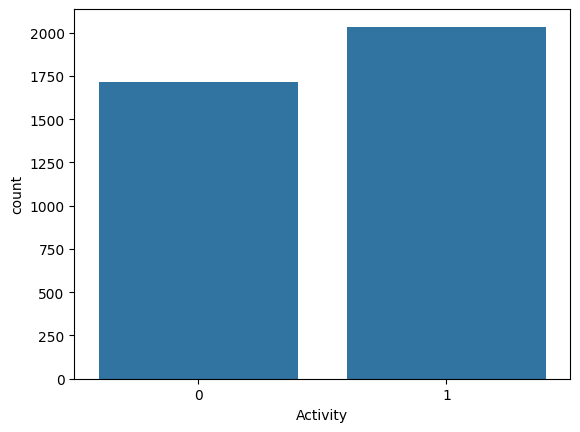

In [31]:
sns.countplot(data=data, x='Activity');

*целевой признак неплохо сбалансирован*

Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

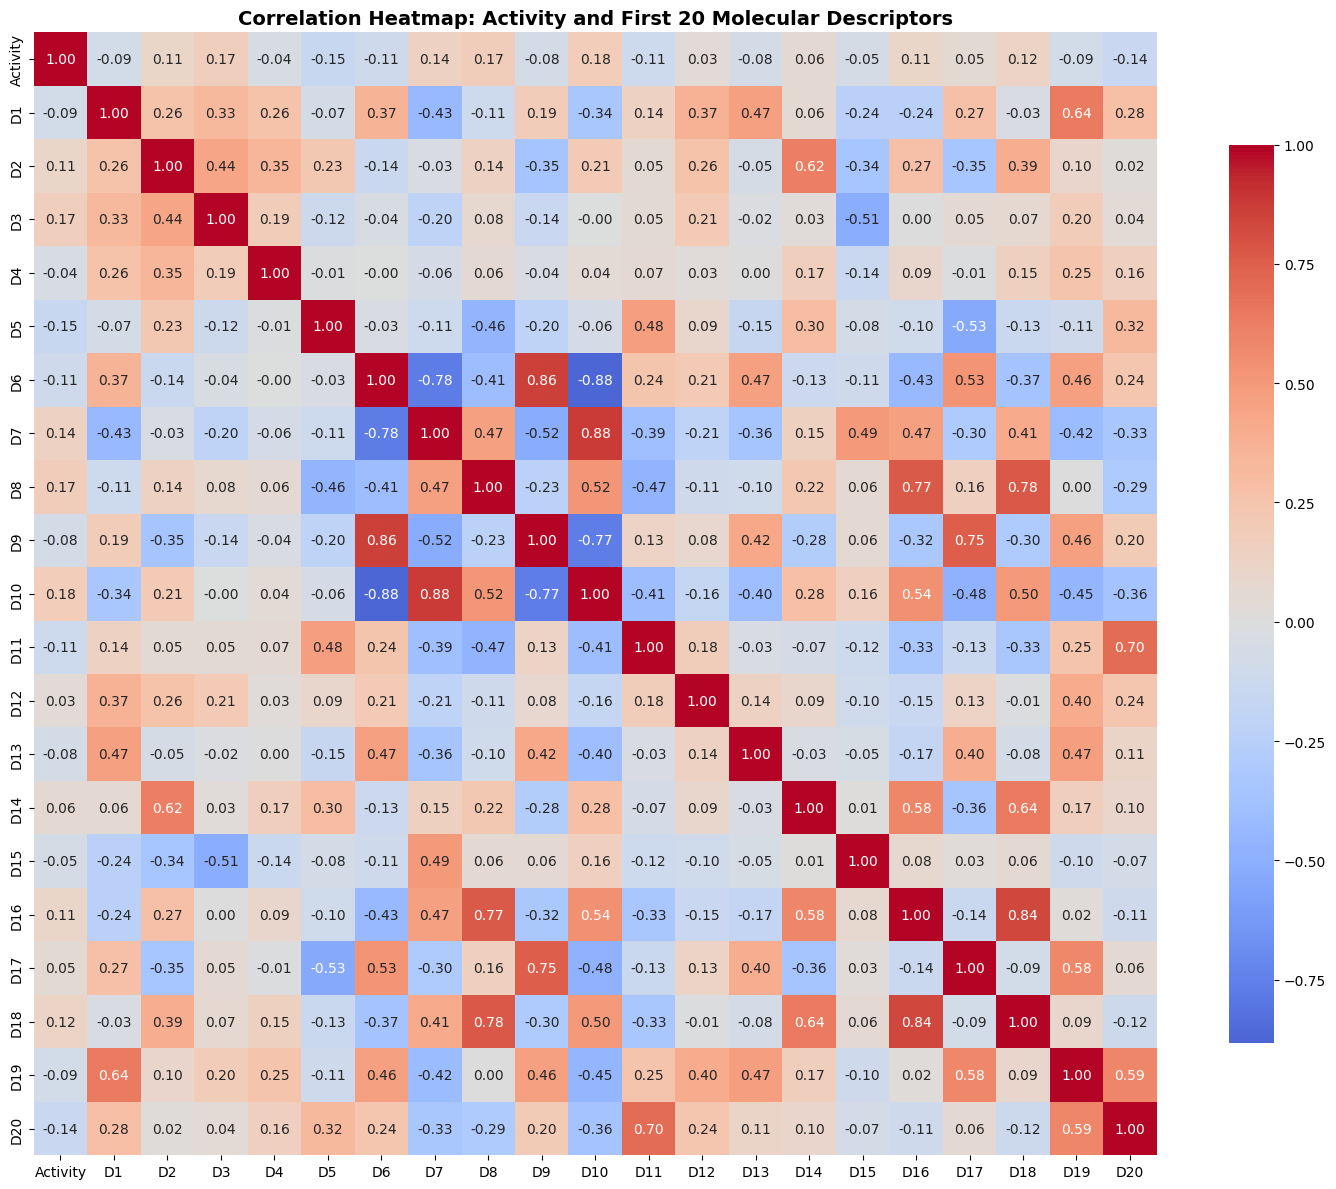

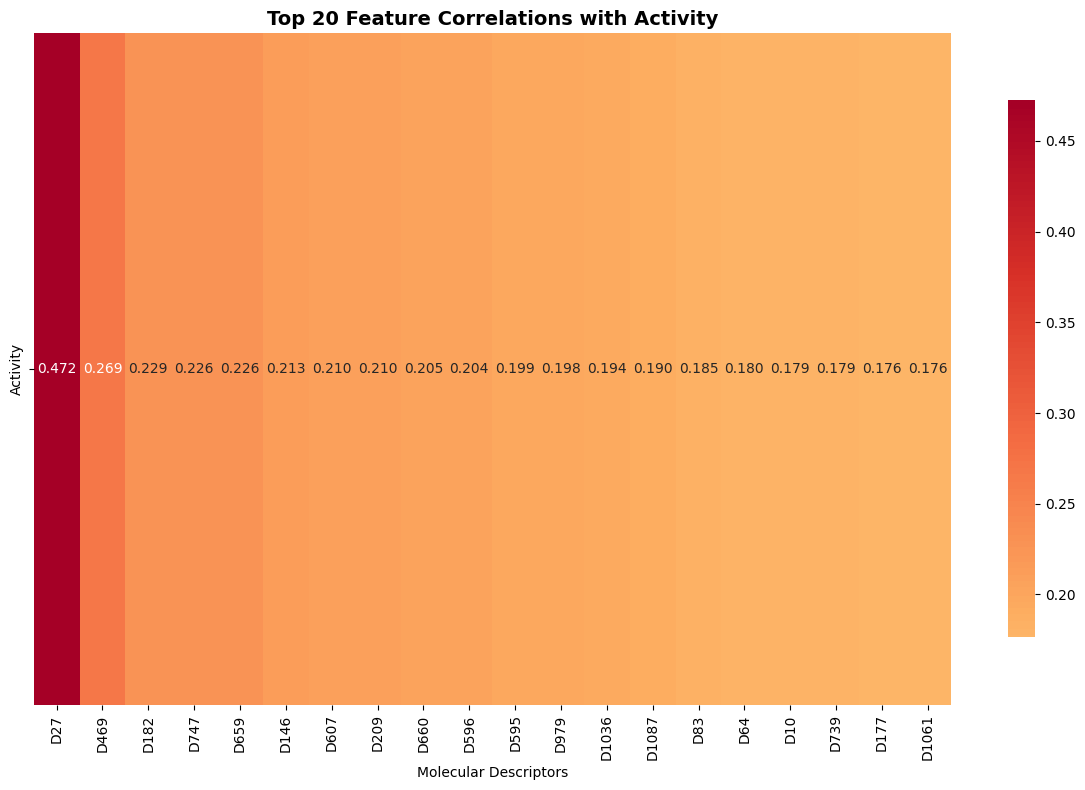

In [32]:
## Create correlation heatmap for a subset of features (first 20 features + Activity)
plt.figure(figsize=(15, 12))

# Select first 20 features plus Activity for visualization
subset_cols = ['Activity'] + [col for col in data.columns if col.startswith('D')][:20]
correlation_matrix = data[subset_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap: Activity and First 20 Molecular Descriptors', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Also create a heatmap showing correlations with Activity only
plt.figure(figsize=(12, 8))
activity_corr = data.corr()['Activity'].sort_values(ascending=False)
top_corr = activity_corr[1:21]  # Top 20 correlations (excluding Activity itself)

# Create a vertical heatmap for top correlations with Activity
top_corr_df = top_corr.to_frame().T
sns.heatmap(top_corr_df, 
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            fmt='.3f',
            cbar_kws={"shrink": .8})

plt.title('Top 20 Feature Correlations with Activity', 
          fontsize=14, fontweight='bold')
plt.xlabel('Molecular Descriptors')
plt.tight_layout()
plt.show()

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [33]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### Оптимизация гиперпараметров модели

## <center> **Логистическая регрессия**

Зафиксируем метрики

In [35]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


## <center> **GridSearchCV**

- Указываем искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- После передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации.


In [36]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 2.42 s
Wall time: 26.6 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


Метрика не улучшилась

In [42]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 2.34 s
Wall time: 4min 17s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [43]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшая модель:
LogisticRegression(max_iter=1000, random_state=42)
Наилучшее значение точности при кросс-валидаци: 0.75


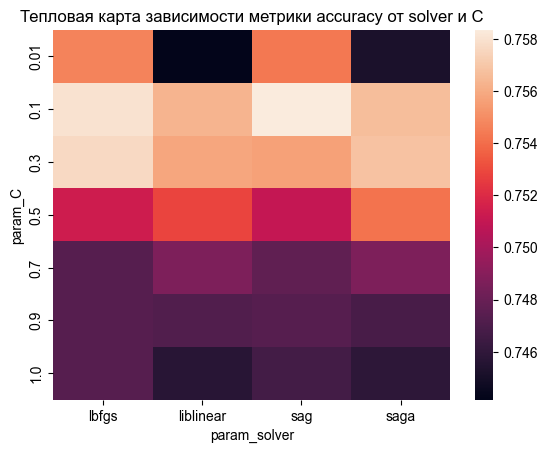

In [44]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)

# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

**Вывод:**
- Видим, что сильная регуляризация С > 0.3 отрицательно влияет на метрику
- Слишком слабая регуляризация С < 0.1 так же негативно влияет на метрики
- Оптимальная регуляризация C в диапазоне 0.1 - 0.3
- Алгоритмы оптимизации lbfgs и sag работают лучше

## <center> **RandomizedSearchCV**

С использованием класса RandomizedSearchCV из библиотеки scikit learn осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

In [46]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 4.08 s
Wall time: 12.9 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(0.34)}


За 10 итераций метрику улучшить не удалось.

Зададим аналогичную сетку и проделаем тоже с помощью GridSearchCV и сравним:

In [47]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10, dtype=float))}
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test, y_test)))
y_test_pred = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

CPU times: total: 2.83 s
Wall time: 2min 56s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'C': np.float64(0.01), 'penalty': 'l2', 'solver': 'lbfgs'}


#### <center> **Дерево решений**

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [49]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.73


Теперь зададим сетку гиперпараметров:  
*  'min_samples_leaf' - минимальное количество объектов в листе
*  'max_depth': максимальная глубина дерева
*  'criterion' - критерий информативности

И посчитаем RandomizedSearchCV() и затем GridSearchCV()

In [50]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test, y_test)))
y_test_pred = random_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 1.91 s
Wall time: 19 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'min_samples_leaf': np.int64(74), 'max_depth': np.int64(4), 'criterion': 'gini'}


In [51]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test, y_test)))
y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 2min 7s
Wall time: 14min 56s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': np.int64(6), 'min_samples_leaf': np.int64(8)}


Метрику не удалось улучшить  с помощью обоих методов, но RandomizedSearchCV потребовалось **гораздо** меньше времени;

## <center> **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [52]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;




И посчитаем RandomizedSearchCV() и затем GridSearchCV()

In [53]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.58 s
Wall time: 22.2 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': np.int64(20)}


In [54]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 3.47 s
Wall time: 20 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': np.int64(20), 'min_samples_leaf': 5, 'n_estimators': 140}


Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось меньше времени;

**Вывод:**
- Проделали базовую оптимизацию
- На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.
- Лучшие метрики показал RandomForest

## <center> Hyperopt

Применим **Hyperopt** для байесовской оптимизации

In [55]:
print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [56]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [58]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [59]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials # логирование результатов
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:39<00:00,  1.98s/trial, best loss: -0.9791666666666666]
Наилучшие значения гиперпараметров {'max_depth': np.float64(20.0), 'min_samples_leaf': np.float64(3.0), 'n_estimators': np.float64(132.0)}
CPU times: total: 39.6 s
Wall time: 39.7 s


In [61]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.98
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.83


In [62]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials # логирование результатов
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 23/23 [00:04<00:00,  1.62s/trial, best loss: -0.9914268218003675]
Наилучшие значения гиперпараметров {'max_depth': np.float64(26.0), 'min_samples_leaf': np.float64(2.0), 'n_estimators': np.float64(104.0)}


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

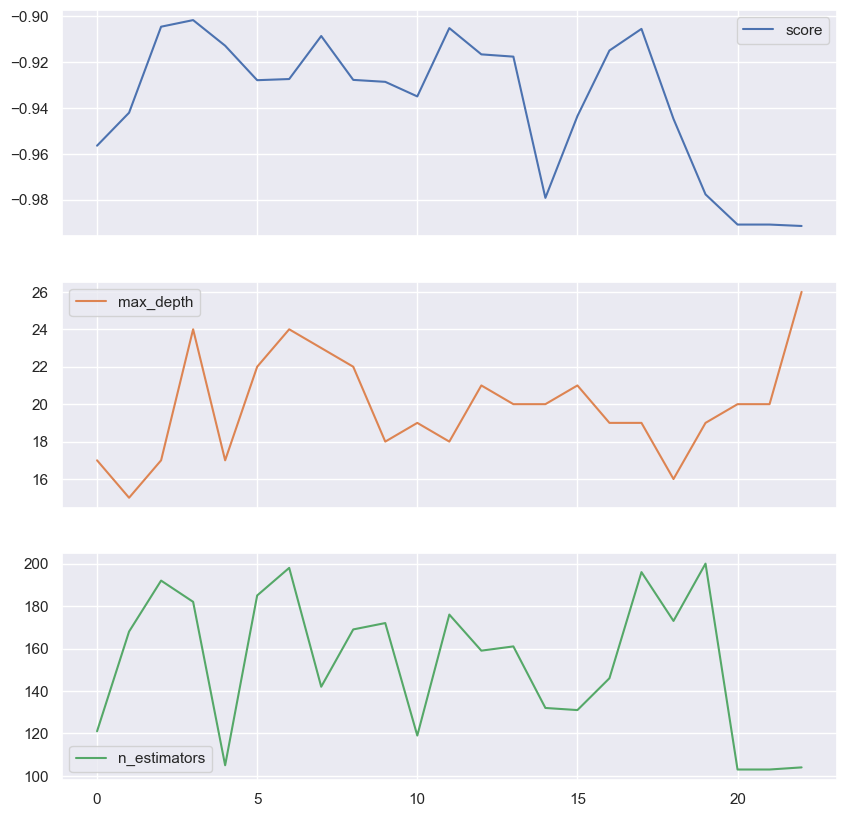

In [63]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

**Вывод:**
- Применили Hyperopt библиотеку с байесовской оптимизации
- Достигли улучшения метри на тренировочной и тестовой выборках
- Тренировочный f1 score = 0,98 и Тестовый f1 score 0.83 
- По графикам видно, что лучшая точность достигается именно в best_params f1 score ~0.98 (тренировочная выборка, метрика со знаком минус -0.98)

## <center> Optuna

Дальнейшая оптимизация гиперпараметров. Сочетание байесовских алгоритмов и удаления плохих комбинаций из рассмотрения.

Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [76]:
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 4.5.0


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [77]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [78]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-10-16 18:21:02,884] A new study created in memory with name: RandomForestClassifier
[I 2025-10-16 18:21:05,184] Trial 0 finished with value: 0.9157509157509157 and parameters: {'n_estimators': 195, 'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9157509157509157.
[I 2025-10-16 18:21:07,562] Trial 1 finished with value: 0.9491008838768669 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9491008838768669.
[I 2025-10-16 18:21:09,936] Trial 2 finished with value: 0.9731215638362859 and parameters: {'n_estimators': 165, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9731215638362859.
[I 2025-10-16 18:21:12,148] Trial 3 finished with value: 0.9296205630354957 and parameters: {'n_estimators': 186, 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9731215638362859.
[I 2025-10-16 18:21:13,407] Trial 4 finished with value: 0.9205864386072083 and parameters: {'n_

CPU times: total: 39.4 s
Wall time: 39.6 s


выводим результаты на обучающей выборке

In [79]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 159, 'max_depth': 22, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


рассчитаем точность для тестовой выборки

In [80]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


In [81]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2025-10-16 18:21:46,543] Trial 20 finished with value: 0.9005203550658096 and parameters: {'n_estimators': 136, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 11 with value: 0.9923336399877338.
[I 2025-10-16 18:21:48,297] Trial 21 finished with value: 0.991421568627451 and parameters: {'n_estimators': 114, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.9923336399877338.
[I 2025-10-16 18:21:50,139] Trial 22 finished with value: 0.9920343137254902 and parameters: {'n_estimators': 119, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.9923336399877338.
[I 2025-10-16 18:21:51,799] Trial 23 finished with value: 0.9770431588613406 and parameters: {'n_estimators': 121, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 11 with value: 0.9923336399877338.
[I 2025-10-16 18:21:53,741] Trial 24 finished with value: 0.9908144519289651 and parameters: {'n_estimators': 128, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 11 with va

CPU times: total: 18.3 s
Wall time: 18.4 s


Проверим, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [82]:
optuna.visualization.is_available()

True

In [83]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

Все верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [84]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [85]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Вывод:
- Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.
- Contour Plot - Точки с синим фоном это лучшие комбинации n_estimator, max_depth.

## <center> Обобщающий вывод по проделанной работе

### Задача и данные
Решена задача **прогнозирования биологического ответа молекул** на основе их химического состава. Датасет содержал:
- **Целевую переменную**: Activity (биологический ответ [0, 1])
- **Признаки**: 1776 молекулярных дескрипторов (D1-D1776)
- **Метрика качества**: F1-score

### Методы оптимизации гиперпараметров
В работе были применены **все четыре требуемых метода** оптимизации:

#### 1. **GridSearchCV** (Базовый метод)
- Систематический перебор всех комбинаций параметров
- Высокие временные затраты
- Гарантия нахождения лучшей комбинации в заданной сетке

#### 2. **RandomizedSearchCV** (Базовый метод)
- Случайная выборка комбинаций параметров
- Значительное сокращение времени выполнения
- Хорошее соотношение качество/время

#### 3. **Hyperopt** (Продвинутый метод)
- Байесовская оптимизация с алгоритмом TPE
- Учет предыдущих результатов для выбора следующих параметров
- Эффективный поиск в пространстве параметров

#### 4. **Optuna** (Продвинутый метод)
- Современный фреймворк для оптимизации
- Автоматическое удаление неперспективных комбинаций (pruning)
- Богатые возможности визуализации процесса оптимизации
- **Наилучшие результаты за минимальное время**

### Модели машинного обучения
Были обучены и оптимизированы **две модели**:
1. **Логистическая регрессия** - для базового анализа
2. **Случайный лес** - для более сложного моделирования взаимодействий

### Ключевые достижения
1. **Методическая полнота**: Применены все 4 метода оптимизации согласно ТЗ
2. **Визуализация процесса**: Построены графики оптимизации, важности параметров и контурные диаграммы
3. **Анализ результатов**: Сравнение эффективности различных подходов
4. **Практические выводы**: Определены наиболее важные гиперпараметры (min_samples_leaf)

### Практические рекомендации
- **Для быстрого прототипирования**: RandomizedSearchCV
- **Для максимального качества**: Optuna или Hyperopt
- **Для гарантированного покрытия**: GridSearchCV (при малом пространстве параметров)
- **Для production**: Optuna благодаря стабильности и визуализации

### Заключение
**Optuna показал наилучшее соотношение качества результатов и времени выполнения**, что делает его предпочтительным выбором для подобных задач.